# Tracking + Anomaly Detection in Avenue Dataset

## Dataset used: **Avenue Dataset for Abnormal Event Detection**



This dataset accompanies paper "Abnormal Event Detection at 150 FPS in Matlab, Cewu Lu, Jianping Shi, Jiaya Jia, International Conference on Computer Vision, (ICCV), 2013"









### Importing required libraries

In [2]:
import os
import cv2
import torch
import shutil
import random
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)

#### Use the best YOLOv5 model u have trained

In [3]:
os.getcwd()

'/mnt/c/Users/ADISH GUPTA/Desktop/SOC IITB 25'

In [4]:
model_path = 'yolov5/runs/train/results_5/weights/best.pt'

In [5]:
# Load YOLOv5 model
model = torch.hub.load('yolov5', 'custom', path= model_path, source='local')
model.conf = 0.25
model.iou = 0.45

/mnt/c/Users/ADISH GUPTA/Desktop/SOC IITB 25/yolov5/utils/general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
fatal: cannot change to '/mnt/c/Users/ADISH': Not a directory
YOLOv5 🚀 2025-7-26 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


/mnt/c/Users/ADISH GUPTA/Desktop/SOC IITB 25/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


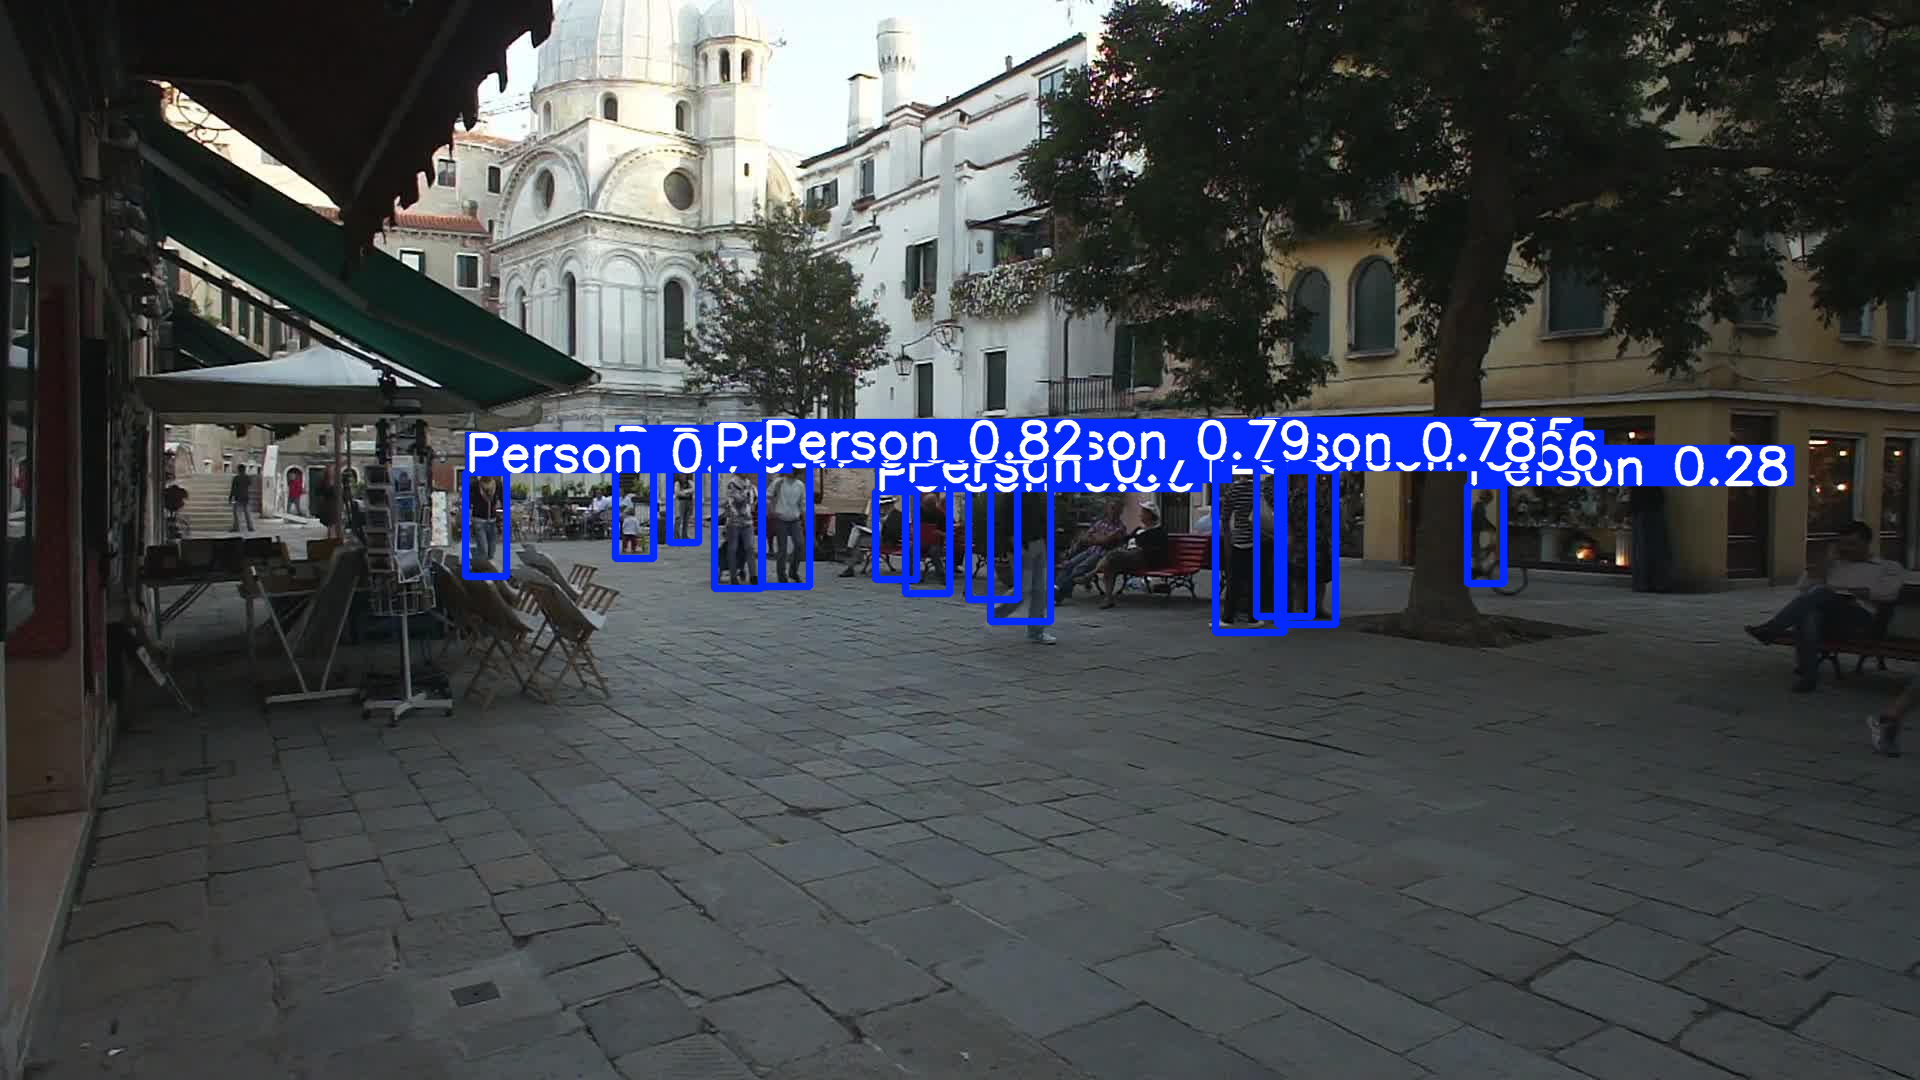

In [6]:
results = model('MOT17_YOLOv5/test/images/MOT17-01_000001.jpg')
results.show()

In [7]:
! pip install deep_sort_realtime opencv-python tqdm

In [8]:
from deep_sort_realtime.deepsort_tracker import DeepSort

In [9]:
output_video_folder = "output_video"
os.makedirs(output_video_folder, exist_ok = True)

In [10]:
os.getcwd()

'/mnt/c/Users/ADISH GUPTA/Desktop/SOC IITB 25'

In [16]:
input_video_path = './Avenue Dataset/testing_videos/01.avi'
output_video_path = "./output_video/output.mp4"

In [21]:
N_history = 20            # how many frames to use for velocity calc
smoothing_frames = 10     # Smoothing: once RED, stay RED for N frames
velocity_threshold = 150   # Velocity threshold (pixels per second)

In [22]:
# Init DeepSORT tracker
tracker = DeepSort(max_age=30)

# Input video
cap = cv2.VideoCapture(input_video_path)

# Get video info
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video: {fps} FPS, {width}x{height}, {frame_count} frames")

# Prepare output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

read_count = 0
frame_idx = 0
pbar = tqdm(total=frame_count)

track_memory = {}     # Memory for tracking: store last N positions
anomaly_memory = {}   # store last anomaly state (for smoothing)

saved_anomaly_ids = set()   # to avoid saving duplicates
max_anomaly_frames = 500    # limit on the frames saved

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # YOLO Inference
    results = model(frame)
    detections = results.xyxy[0].cpu().numpy()  # (xmin, ymin, xmax, ymax, conf, cls)

    # Format detections for DeepSORT
    formatted_detections = []
    for d in detections:
        xmin, ymin, xmax, ymax, conf, cls = d
        width_box = xmax - xmin
        height_box = ymax - ymin
        box = [xmin, ymin, width_box, height_box]
        formatted_detections.append([box, conf])

    # Update tracker
    tracks = tracker.update_tracks(formatted_detections, frame=frame)

    # Draw tracks
    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id   # unique ID assigned to the pedestrian
        ltrb = track.to_ltrb()      # gives [left, top, right, bottom] of bounding box
        xmin, ymin, xmax, ymax = map(int, ltrb)

        # Center point
        center_x = (xmin + xmax) / 2
        center_y = (ymin + ymax) / 2

        # Update history
        track_memory.setdefault(track_id, []).append((frame_idx, center_x, center_y))
        track_memory[track_id] = track_memory[track_id][-N_history:]

        # Calculate velocity
        if len(track_memory[track_id]) >= 2:
            f1, x1, y1 = track_memory[track_id][0]
            f2, x2, y2 = track_memory[track_id][-1]

            dt = (f2 - f1) / fps  # time in seconds
            dx = x2 - x1
            dy = y2 - y1
            distance = np.sqrt(dx**2 + dy**2)

            velocity = distance / (dt + 1e-6)  # avoid zero div

            # Anomaly flag
            if velocity > velocity_threshold:
                anomaly = True
            else:
                anomaly = False
        else:
            anomaly = False


        if anomaly:
            anomaly_memory[track_id] = frame_idx  # mark when anomaly seen

        if track_id in anomaly_memory:
            if frame_idx - anomaly_memory[track_id] <= smoothing_frames:
                anomaly = True  # force RED

        # Drawing boxes only around the anomaly
        if anomaly:

          label = f"ID {track_id} {'ANOMALY'}"
          color = (0, 0, 255)

          cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 1)
          cv2.putText(frame, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


    # Write frame
    out.write(frame)

    frame_idx += 1
    read_count += 1
    pbar.update(1)

pbar.close()
cap.release()
out.release()

print(f"Frames read: {read_count} / {frame_count}")
print(f"\n DONE — output saved to: {output_video_path}")

Video: 25.0 FPS, 640x360, 1439 frames


  0%|                                                                                                    | 0/1439 [00:00<?, ?it/s]/mnt/c/Users/ADISH GUPTA/Desktop/SOC IITB 25/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
  0%|                                                                                            | 1/1439 [00:00<03:49,  6.27it/s]/mnt/c/Users/ADISH GUPTA/Desktop/SOC IITB 25/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/mnt/c/Users/ADISH GUPTA/Desktop/SOC IITB 25/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/mnt/c/Users/ADISH GUPTA/Desktop/SOC IITB 25/yolov5/mode

Frames read: 1439 / 1439

 DONE — output saved to: ./output_video/output.mp4
